## Group Project Report: Predicting Heart Disease Using knn classification
Nethkini Liyanage - Charlotte Du - Andrew Young Liu - Vivian Khong

In [1]:
#load packages
library(tidyverse)
library(tidymodels)
library(dplyr)
library(gridExtra)

# set the seed
set.seed(1)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Introduction: - straight copied from proposal, need update
Heart disease pertains to be one of the major causes of death (1 in 5) in America and many other countries. Factors including cholesterol, blood pressure, and blood sugar levels, among many others, are critical indicators of heart disease risk and contribute to narrowing arteries and reducing blood flow to the heart, increasing the chances of heart attacks and other cardiovascular complications. Managing these levels is crucial in preventing heart disease.  Using medical equipment such as X-rays and ECGs is too costly and is not readily available to be used across the world. The “Heart Disease” dataset donated by researchers at the Department of Medicine, Veterans Administration Medical Center, Long Beach California in 1988 includes 14 attributes and a target variable indicating the presence or absence of heart disease. The dataset contains data from patient test groups from Switzerland, America, and Hungary. This project utilizes the database from Cleveland, Ohio to determine if cases of heart disease can be accurately classified using  maximum heart rate achieved during exercise (thalach), ST depression induced by exercise relative to rest (oldpeak), and number of major vessels (ca). 

## Methods & Results

### Loading Data into R

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# create readable column name tibble
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "heart_disease_presence")
# read the data into R
cleveland_data <- read.csv(url, header = FALSE,, col.names = column_names)

# view the first few rows of the data and have a glipmse
head(cleveland_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### Cleaning and Wrangling data

#### Convert data types

In [3]:
# convert 0 to 'no' and 1-3 to 'yes' for heart_disease_presence column
cleveland_data$heart_disease_presence <- ifelse(cleveland_data$heart_disease_presence == 0, 'no', 'yes')

# convert the column types of ca and heart_disease_presence
cleveland_data <- mutate(cleveland_data, ca = as.numeric(ca), 
    heart_disease_presence = as.factor(heart_disease_presence))

# see first 6 rows to check the effect
head(cleveland_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion”


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,no
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,yes
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,yes
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,no
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,no
6,56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,no


#### Count the numer of rows having missing data then filter them out

In [4]:
# summarize the number of observations that are "NA"
cleveland_data |>
  summarise(
    na_count = sum(rowSums(is.na(cleveland_data)))
  )

na_count
<dbl>
4


Table 1

In [5]:
# delete these rows
cleveland_data <- na.omit(cleveland_data)

In [6]:
# summarize the number of observations that are "?"
question_mark__count <- data.frame(t(colSums(cleveland_data == "?")))
question_mark__count

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,2,0


Table 2

In [7]:
# delete rows with "?"
cleveland_data <- filter(cleveland_data, thal != "?", ca != "?")

### Data Split

In [8]:
# split the data to 75% training and 25% testing
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = heart_disease_presence)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

# show the head of the traning data
head(cleveland_train)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,no
2,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,no
3,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,no
4,57,1,4,140,192,0,0,148,0,0.4,2,0,6.0,no
5,56,0,2,140,294,0,2,153,0,1.3,2,0,3.0,no
6,57,1,3,150,168,0,0,174,0,1.6,1,0,3.0,no


### Summary Tables of Class Distribution of Training Data

In [9]:
# Summary table with count of observations, mean of potential predictors
summary_table <- cleveland_train |>
  summarise(
    Count_Yes = sum(heart_disease_presence == "yes"),
    Count_No = sum(heart_disease_presence == "no"),
    Mean_trestbps = mean(trestbps),
    Mean_thalach = mean(thalach),
    Mean_oldpeak = mean(oldpeak),
    Mean_chol = mean(chol),
    Mean_ca = mean(ca),
  )
summary_table

Count_Yes,Count_No,Mean_trestbps,Mean_thalach,Mean_oldpeak,Mean_chol,Mean_ca
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102,120,132.3604,149.6216,1.058108,246.8649,0.6666667


Table 3

### Visualizations of Potential Predictor Variables

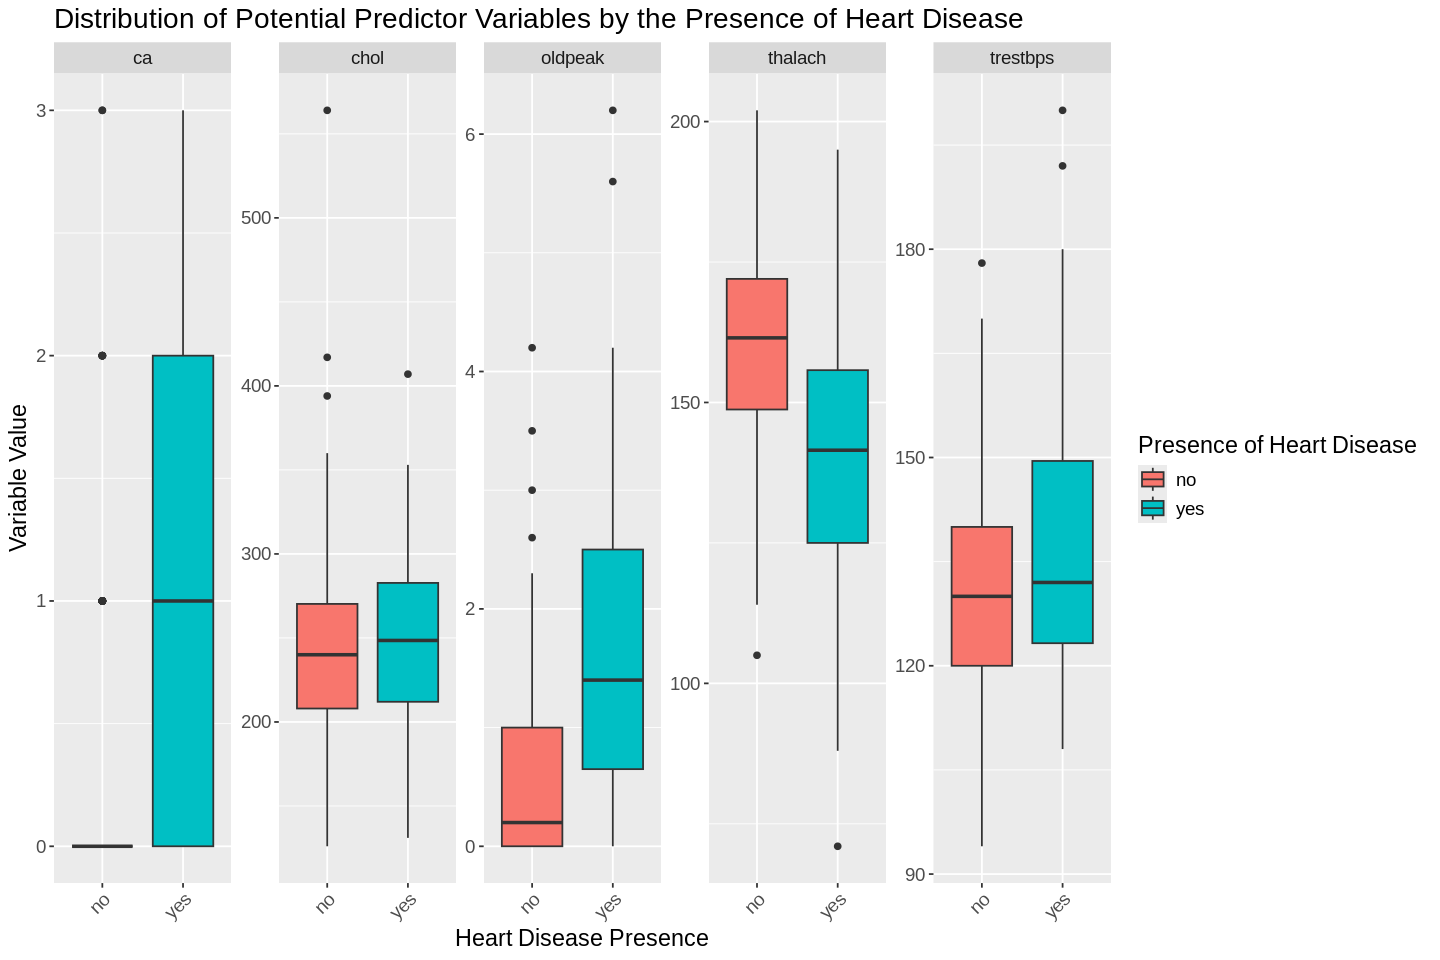

In [10]:
# box plots visualization of the data
options(repr.plot.width=12, repr.plot.height=8)

long_data <- cleveland_train |>
  pivot_longer(cols = c(trestbps, thalach, oldpeak, chol, ca), names_to = "variable", values_to = "value")

ggplot(long_data, aes(x = heart_disease_presence, y = value, fill = heart_disease_presence)) +
  geom_boxplot() +
  facet_wrap(~variable, scales = 'free', ncol = 5) +
  labs(x = "Heart Disease Presence", y = "Variable Value", fill = "Presence of Heart Disease", title = "Distribution of Potential Predictor Variables by the Presence of Heart Disease") +
  theme(text = element_text(size = 14), axis.text.x = element_text(angle = 45, hjust = 1))

Figure 1

### Classification Data Analysis

#### Predictors Selection and its Reasoning

By observing the above boxplots side by side, we decided that the variables 'ca,' 'oldpeak,' and 'thalach' should be selected as predictors for our analysis, as they exhibit statistically significant variation in the boxplot when comparing different categories of heart condition presence and are unlikely due to sampling variability.

#### Preprocess the Data

In [11]:
# scale and center training data
cleveland_recipe <- recipe(heart_disease_presence ~ ca + chol + oldpeak, data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#### Tuning the Classifier

In [12]:
# create K-nearest neighbor model specification with tune
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# 5-fold cross-validation
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = heart_disease_presence)

# create a Ks' data frame from 1 to 20
grid_vals <- tibble(neighbors = seq(1, 20))

# workflow analysis combines recipe and model
knn__results <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cleveland_vfold, grid = grid_vals) |>
  collect_metrics()

#### Print Accuracies for ALL Ks

In [13]:
accuracy_results <- knn__results |> 
  filter(.metric == "accuracy")
accuracy_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7117172,5,0.02052855,Preprocessor1_Model01
2,accuracy,binary,0.7252525,5,0.01281774,Preprocessor1_Model02
3,accuracy,binary,0.7253535,5,0.03117205,Preprocessor1_Model03
4,accuracy,binary,0.7253535,5,0.03117205,Preprocessor1_Model04
5,accuracy,binary,0.7747475,5,0.02367766,Preprocessor1_Model05
6,accuracy,binary,0.7747475,5,0.02367766,Preprocessor1_Model06
7,accuracy,binary,0.7705051,5,0.03091247,Preprocessor1_Model07
8,accuracy,binary,0.7705051,5,0.03091247,Preprocessor1_Model08
9,accuracy,binary,0.7389899,5,0.02844578,Preprocessor1_Model09


Table 4

#### Ploting the Accuracy vs k

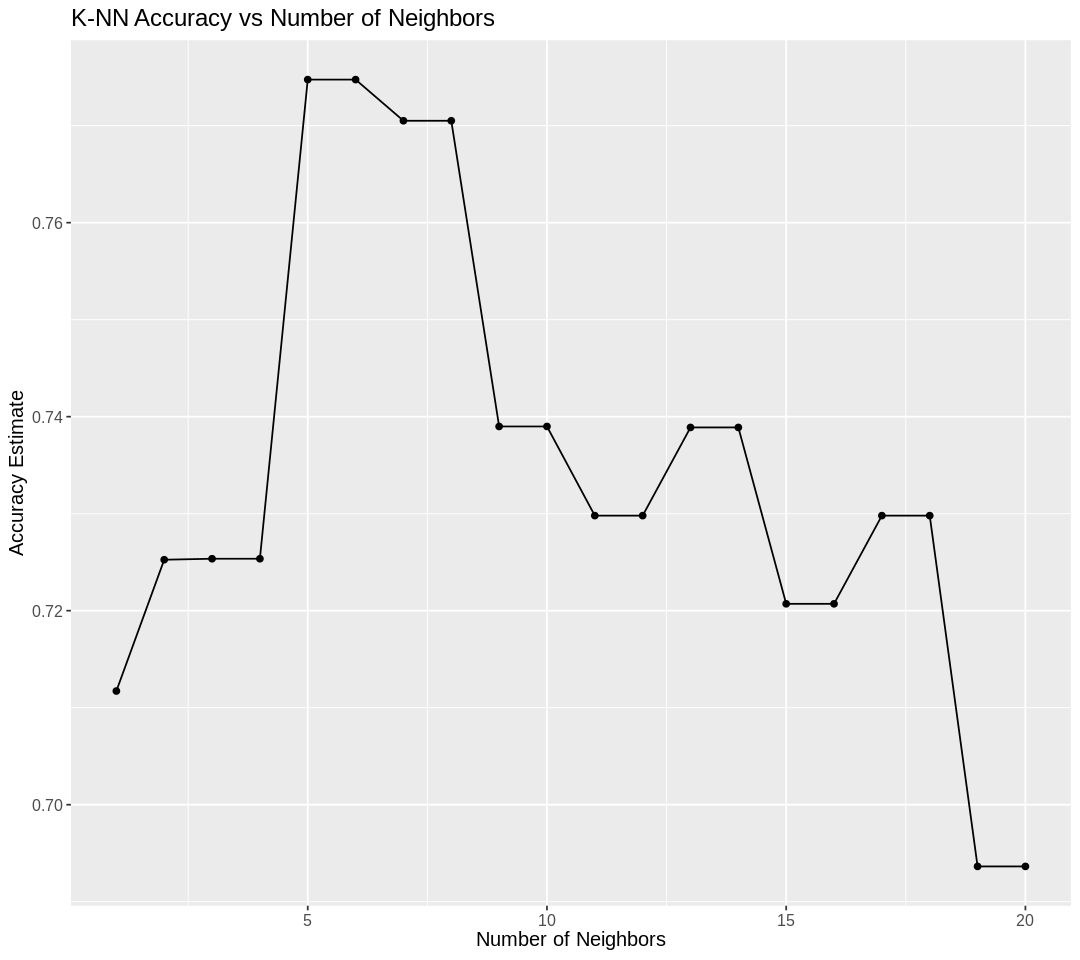

In [49]:
options(repr.plot.width= 9, repr.plot.height = 8)

accuracy_plot <- ggplot(accuracy_results, aes(x = neighbors, y = mean)) +
geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors", y = "Accuracy Estimate", title = "K-NN Accuracy vs Number of Neighbors") +
  theme(text = element_text(size = 12))
accuracy_plot

Figure 2

#### Obtain the Number of Neighbours with the Highest Accuracy

In [15]:
best_k <- accuracy_results |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_k

[1] 5

#### Retrain the Classifier with the Best K

In [16]:
# reconstruct the model with the best k
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

best_k_recipe <- recipe(heart_disease_presence ~ ca + chol + oldpeak, data = cleveland_train) |>
     step_scale(all_predictors()) |>
    step_center(all_predictors())

best_knn_fit <- workflow() |>
  add_recipe(best_k_recipe) |>
  add_model(best_k_spec) |>
  fit(data = cleveland_train)

#### Predict Lables on the Testing Data

In [17]:
# predict the test set
cleveland_test_predictions <- predict(best_knn_fit, cleveland_test) |>
  bind_cols(cleveland_test)
head(cleveland_test_predictions)

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
no,56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,no
yes,62,0,4,140,268,0,2,160,0,3.6,3,2,3.0,yes
no,57,0,4,120,354,0,0,163,1,0.6,1,0,3.0,no
no,44,1,2,120,263,0,0,173,0,0.0,1,0,7.0,no
no,52,1,3,172,199,1,0,162,0,0.5,1,0,7.0,no
no,54,1,4,140,239,0,0,160,0,1.2,1,0,3.0,no


Table 5

### Evaluate the Performance

- Accuracy

In [18]:
cleveland_accuracy <- cleveland_test_predictions |>
    metrics(truth = heart_disease_presence, estimate = .pred_class) |>
    filter(.metric == "accuracy")
cleveland_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7866667


Table 6

- Check the order of the labels

In [19]:
# check the order of the labels in the heart_disease_presence variable
cleveland_test_predictions |> pull(heart_disease_presence) |> levels()

[1] "no"  "yes"

- Precision

In [20]:
# above result shows that "yes" is the second level so we specify the "positive" class corresponds to the second factor level thru event_level
cleveland_pre <- cleveland_test_predictions |>
  precision(truth = heart_disease_presence, estimate = .pred_class, event_level = "second")
cleveland_pre

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8518519


Table 7

- Recall

In [21]:
cleveland_re <- cleveland_test_predictions |>
  recall(truth = heart_disease_presence, estimate = .pred_class,event_level = "second")
cleveland_re

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6571429


Table 8

- Confusion Matrix

In [22]:
cleveland_con <- cleveland_test_predictions |>
  conf_mat(truth = heart_disease_presence, estimate = .pred_class)
cleveland_con

          Truth
Prediction no yes
       no  36  12
       yes  4  23

Table 9

### Visualization of the Analysis

In Table 6, we see that our classfier identified 23 out of 35 heart disease presence, and 36 out of 40 non-heart disease presence.

In [34]:
# calculate the percentage of our classifier correctly predict a positive label and a negative respectively
correct_positive_percent <- 23 / (12 + 23)
correct_negative_percent <- 36 / (36 + 4) 

# Create a data frame with the percentages
percentages_df <- data.frame(
  Category = c("Correct Positive", "Correct Negative"),
  Percentage = c(correct_positive_percent, correct_negative_percent)
)
percentages_df

Category,Percentage
<chr>,<dbl>
Correct Positive,0.6571429
Correct Negative,0.9000000


Table 10

We plot the above table in a bar graph.

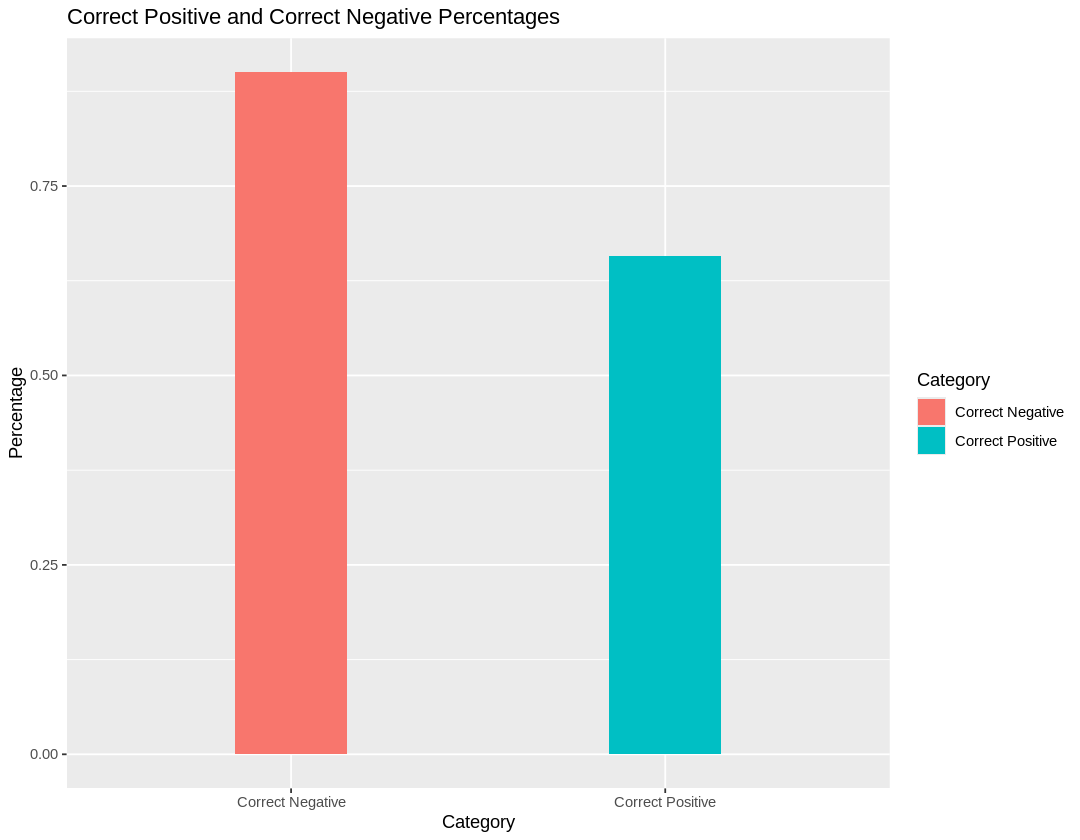

In [51]:
# Create a bar plot
options(repr.plot.width= 9, repr.plot.height = 7)
ggplot(percentages_df, aes(x = Category, y = Percentage, fill = Category)) +
  geom_bar(stat = "identity",width = 0.3) +
  labs(title = "Correct Positive and Correct Negative Percentages", y = "Percentage")

Figure 3

## Discussion  
  * Utilizing the methods of loading data into R, cleaning, wrangling and processing the publicly available heart-disease data donated by researchers at the Department of Medicine, Veterans Administration Medical Center, Long Beach California in 1988, this study created a model to predict whether or not a patient has heart disease using the K-nearest neighbour classification algorithm. This model uses the variables 'ca', 'oldpeak', and 'thalach', as predictors as they displayed statistically significant variation in the boxplots that were created in the prior steps. Using these variables, the data was processed and used to create a k-nearest neighbour model specification with tune. After printing the accuracies for all k values, a plot of K vs accuracy was created to determine that k=5 was the best K value. Lastly, the model was retrained using k=5, and the testing data was used to determine the accuracy, precision, and recall of this model.
  * The trained model with k=5 demonstrated an accuracy of 0.7866667 which indicates that this model correctly predicts the presence or absence of heart disease for approximately 78.67% of the cases in our dataset. Further, a precision of 0.8518519 means that when this model predicts a patient has heart disease, it is correct about 85.19% of the time. Additionally, a recall of 0.6571429 means that our model correctly identifies 65.71% of the patients who actually have heart disease. Overall, this model shows decent overall accuracy in predicting heart disease presence or absence, and it has a moderate ability to correctly identify individuals with heart disease. However, it also indicates that there is room for improvement in accuracy,precision and recall, (especially since it is vital that predictions of heart disease or lack there of be accurate, precise, and have a high recall when informing pateints) suggesting that further optimization or refinement of the model may be beneficial to enhance its performance.From the last visualization, we can also tell that our classifier is better at predicting negative lables than positive labels. It misclassified 35% of the presence of heart disease in the testing data set. In our analysis, misclassifying a heart disease presence is a potentially disastrous error, since it may lead to a patient who requires treatment not receiving it.
  * These results are a relatively accurate reflection of what was expected to be found since we were using publicly available data and only focused on Cleaveland. The accuracy, precision, and recall scores are decent scores for a first model and in the future, to expand and improve this model, further analysis can be conducted, perhaps using a larger data set (beyond just Cleaveland).
  * The findings of this model have several implications including clinical utility, patient care, and an overall positive impact on public health. The basis of this model can be used to aid with preliminary diagnosis of heart disease, thereby increasing methods of preventitive care and potentially decreasing death rates. Additionally, the finding from this model can lead to a lower cost of medical examinations as medical scans such as MRIs, FMIRs, ECG..etc. are qute coslty. Using this model as a predictor fo heart disease can thefore lead to a less medical expenses for patients.
  * The findings of this model also opens doors to many areas of expansion and lead to additianal questions. One pertanat question is "are there ways to further optimize the K-nearest neighbors algorithm parameters to improve model performance?", Further, we can ask, "can the predictive accuracy of this model be enhanced by including more predictor variables?" We can also conduct studies to explore a variety of questions incliding variability between sexes. Lastly, longitudinal studies can also be conducted to assess the model's performance over time. 


## References
1. Heart Disease Dataset UCI Machine Learning Repository. (n.d.). Retrieved from https://archive.ics.uci.edu/dataset/45/heart+disease
2. Heart Disease - Symptoms and Causes - Mayo Clinic. (2022, August 25). Retrieved from https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118#:~:text=Heart%20disease%20describes%20a%20range,born%20with%20(congenital%20heart%20defects)
3. Heart disease and stroke prevention. (n.d.). Retrieved from https://www.health.ny.gov/diseases/cardiovascular/heart_disease/#:~:text=About%20695%2C000%20people%20die%20of,Americans%20have%20a%20heart%20attack.